In [134]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os


from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.layer_utils import get_source_inputs
from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
from keras.models import Model
import keras.backend as K
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D

In [135]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 14

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024


In [136]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)


Total videos for training: 800
Total videos for testing: 200


,video_name,tag
67,fi168_xvid.avi,violence
344,fi445_xvid.avi,violence
300,fi401_xvid.avi,violence
11,fi112_xvid.avi,violence
398,fi499_xvid.avi,violence
473,no174_xvid.avi,noviolence
617,no318_xvid.avi,noviolence
230,fi331_xvid.avi,violence
621,no322_xvid.avi,noviolence
363,fi464_xvid.avi,violence


In [137]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [138]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


In [139]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())


['noviolence', 'violence']


In [140]:
def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(32,32,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=131):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = _obtain_input_shape(input_shape, default_size=224, min_size=28, require_flatten=include_top,
                                      data_format=K.image_data_format())
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    if input_tensor:
        inputs = get_source_inputs(input_tensor)

    else:
        inputs = img_input

    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

In [141]:
modelSS = ShuffleNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3),load_model=None, classes=131)


In [142]:

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                numpy_array = modelSS.predict( batch[None, j, :])
                # print(numpy_array[0])
                temp_frame_features[i, j, :] =numpy_array
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")


Frame features in train set: (800, 20, 1024)
Frame masks in train set: (800, 20)


In [143]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/14
18/18 [==============================] - 12s 163ms/step - loss: 0.6556 - accuracy: 0.7054 - val_loss: 0.9806 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.98060, saving model to tmp\video_classifier
Epoch 2/14
18/18 [==============================] - 1s 47ms/step - loss: 0.6037 - accuracy: 0.7143 - val_loss: 1.2805 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.98060
Epoch 3/14
18/18 [==============================] - 1s 52ms/step - loss: 0.6061 - accuracy: 0.7143 - val_loss: 1.2328 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.98060
Epoch 4/14
18/18 [==============================] - 1s 39ms/step - loss: 0.6039 - accuracy: 0.7143 - val_loss: 1.2053 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 0.98060
Epoch 5/14
18/18 [==============================] - 1s 43ms/step - loss: 0.6105 - accuracy: 0.7143 - val_loss: 1.1516 - val_accuracy: 0.0000e+00

Epoch 00005: val_loss did 

Test video path: fi30_xvid.avi
  violence: 62.46%
  noviolence: 37.54%



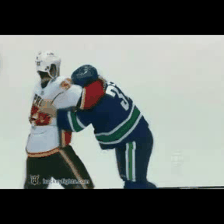

In [144]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            numpy_array = modelSS.predict( batch[None, j, :])
            frame_features[i, j, :] = numpy_array
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])


In [145]:
model = ShuffleNetV2(include_top=False, input_shape=(32, 32, 3),load_model=None, classes=131)
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "ShuffleNetV2_1.0_1_373"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 24)   648         input_57[0][0]                   
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 8, 8, 24)     0           conv1[0][0]                      
__________________________________________________________________________________________________
stage2/block1/1x1conv_1 (Conv2D (None, 8, 8, 116)    2900        maxpool1[0][0]                   
_____________________________________________________________________________